## Straight solving and verifying

In [9]:
Shapes_open = {
    'Stick': {
        'z': {'nz': 6, 'ny': 6, 'nx': 25},
        'y': {'nz': 6, 'ny': 5, 'nx': 24},
        'x': {'nz': 5, 'ny': 6, 'nx': 24}
        },
    'Flat': {
        'z': {'nz': 16, 'ny': 16, 'nx': 5},
        'y': {'nz': 16, 'ny': 15, 'nx': 4},
        'x': {'nz': 15, 'ny': 16, 'nx': 4}
        },
    'Cube':{
        'z': {'nz': 10, 'ny': 10, 'nx': 11},
        'y': {'nz': 10, 'ny': 9, 'nx': 10},
        'x': {'nz': 9, 'ny': 10, 'nx': 10}
        }
    }

Shapes_border = {
    'Stick': {
        'z': {'nz': 24, 'ny': 5, 'nx': 5},
        'y': {'nz': 23, 'ny': 6, 'nx': 5},
        'x': {'nz': 23, 'ny': 5, 'nx': 6}
        },
    'Flat': {
        'z': {'nz': 4, 'ny': 15, 'nx': 15},
        'y': {'nz': 3, 'ny': 16, 'nx': 15},
        'x': {'nz': 3, 'ny': 15, 'nx': 16}
        },
    'Cube':{
        'z': {'nz': 10, 'ny':9, 'nx': 9},
        'y': {'nz': 9, 'ny': 10, 'nx': 9},
        'x': {'nz': 9, 'ny': 9, 'nx': 10}
        }
    }

Shapes_anizotropic = {
    'Stick': {
        'z': {'nz': 6, 'ny': 6, 'nx': 25},
        },
    'Flat': {
        'z': {'nz': 16, 'ny': 16, 'nx': 5},
        },
    'Cube':{
        'z': {'nz': 10, 'ny': 10, 'nx': 11},
        }
    }

compessions = [1, 3, 10]



In [10]:
# Calculating currents in each ring on straight way for open or border structure

import numpy as np
from Straight_Method import solvesystem
from Geometry import Rectangle_packing, Ellipse_packing, Cilinder_packing
from Impedance_matrix import M_diag, M_grad, Z_diag, Z_grad
from Verifying_MRI.Parameters_MRI import Dz, Dy, Dx, Radius, omega_0, Params
Params['R'] = 0.00465
Params['L'] = 13.459 * 10 ** -9
Params['C'] = 470 * 10 ** -12
import json

Inductance = {}
omega_0 = 1/np.sqrt(Params['L'] * Params['C'])
Omega =  np.linspace(61e6, 67e6, 1000) * 2 * np.pi
H_0z = 1
mu_0 = 4 * np.pi * 1e-7
# Calculate polarisation for different structures

Dz, Dy, Dx = Params['Dz'], Params['Dy'], Params['Dx']
# Initial position of the first ring for each orientation
R0 = {
    'z': {'nz': 0, 'ny': Dy/2, 'nx': Dx/2},
    'y': {'nz': Dz/2, 'ny': 0, 'nx': Dx/2},
    'x': {'nz': Dz/2, 'ny': Dy/2, 'nx': 0}
}

for name in ['Cube']:
    Params['N'] = Shapes_border[name]
    # make 3d structure
    print(f'Make Rings: {name}, {Params["N"]}')
    Rings_4d ={}
    for pos in Params['N']:
        Rings_4d[pos] = Rectangle_packing(Params, r0 = R0[pos], orientation=pos)
    Rings = np.concatenate([Rings_4d[pos] for pos in Params['N']])
    
    Params['Number'] = len(Rings)
    phi_0z = np.zeros(Params['Number'])

    Number_z = Params['N']['z']['nz'] * Params['N']['z']['ny'] * Params['N']['z']['nx']
    Number_y = Params['N']['y']['nz'] * Params['N']['y']['ny'] * Params['N']['y']['nx']
    Number_x = Params['N']['x']['nz'] * Params['N']['x']['ny'] * Params['N']['x']['nx']

    phi_0z[:Number_z] = H_0z * mu_0*np.pi * Radius ** 2
    Currents = solvesystem(Rings, M_diag(Rings), Omega, phi_0z=phi_0z, Inductance = Inductance)
    Nz, Ny, Nx = [Params['N'][pos][f'n{pos}']-1 for pos in Params['N']]

    P_0z = np.pi * Radius ** 2 /H_0z/Dz/Dy/Dx
    Currents['Params'] = Params
    Currents['RealZPolarisation'] = [P_0z/Number_z * sum(i[:Number_z]) for i in Currents['RealCurrents']]
    Currents['ImagZPolarisation'] = [P_0z/Number_z * sum(i[:Number_z]) for i in Currents['ImagCurrents']]

    dims = ''.join([pos for pos in Params['N']])
    with open(f"Data/Form_Data/izotropic/{name}/S-Currents-{dims}-{Nz}x{Ny}x{Nx}", "w") as f:
        json.dump(Currents, f)

    exclude = ['RealCurrents', 'ImagCurrents']
    data = {key: value for key, value in Currents.items() if key not in exclude}
    with open(f"Data/Form_Data/izotropic/{name}/S-Data-{dims}-{Nz}x{Ny}x{Nx}", "w") as f:
        json.dump(data, f)

Make Rings: Cube, {'z': {'nz': 10, 'ny': 9, 'nx': 9}, 'y': {'nz': 9, 'ny': 10, 'nx': 9}, 'x': {'nz': 9, 'ny': 9, 'nx': 10}}
Matrix forming


100%|██████████| 2430/2430 [00:51<00:00, 47.34it/s] 


Matrix: Done
Straight solving


100%|██████████| 1000/1000 [09:50<00:00,  1.69it/s]


Straight solving: Done


In [3]:
# Calculating currents in each ring on fft way for border structure
import numpy as np
from Fast_Method import solvesystem
from Geometry import Rectangle_packing
from Impedance_matrix import M_grad, Z_grad, M_diag, Z_diag
from Verifying_MRI.Parameters_MRI import Dz, Dy, Dx, Radius, omega_0, Params
Params['R'] = 0.00465
Params['L'] = 13.459 * 10 ** -9
Params['C'] = 470 * 10 ** -12
omega_0 = 1/np.sqrt(Params['L'] * Params['C'])
import json

Inductance = {}
Omega =  np.linspace(61e6, 67e6, 1000) * 2 * np.pi 
omega_0 = 1/np.sqrt(Params['L'] * Params['C'])
H_0z = 1
mu_0 = 4 * np.pi * 1e-7
# Calculate polarisation for different structures

Dz, Dy, Dx = Params['Dz'], Params['Dy'], Params['Dx']
# Initial position of the first ring for each orientation
R0 = {
    'z': {'nz': 0, 'ny': Dy/2, 'nx': Dx/2},
    'y': {'nz': Dz/2, 'ny': 0, 'nx': Dx/2},
    'x': {'nz': Dz/2, 'ny': Dy/2, 'nx': 0}
}

for name in Shapes_border:
    Params['N'] = Shapes_border[name]
    # make 3d structure
    print(f'\n Make rings: {Params["N"]}')
    Rings_4d ={}
    for pos in Params['N']:
        Rings_4d[pos] = np.array(Rectangle_packing(Params, r0 = R0[pos], orientation=pos)).reshape(
                                                     Params['N'][pos]['nz'],
                                                     Params['N'][pos]['ny'],
                                                     Params['N'][pos]['nx'])
    Params['Number'] = int(np.sum([Rings_4d[pos].size for pos in Params['N']]))
    print([Rings_4d[pos].size for pos in Params['N']], Params['Number'])
    Rings = np.concatenate([Rings_4d[pos].flatten() for pos in Params['N']])
    phi_0z = np.zeros(Params['Number'])
    Number_z = Params['N']['z']['nz'] * Params['N']['z']['ny'] * Params['N']['z']['nx']
    Number_y = Params['N']['y']['nz'] * Params['N']['y']['ny'] * Params['N']['y']['nx']
    Number_x = Params['N']['x']['nz'] * Params['N']['x']['ny'] * Params['N']['x']['nx']
    phi_0z[:Number_z] = H_0z * mu_0*np.pi * Radius ** 2

    print(f'Frequency modeling: {round(Omega[0]/2/np.pi/1e6, 1)}-{round(Omega[-1]/2/np.pi/1e6, 2)} MHz')
    Currents = solvesystem(Rings_4d, M_diag(Rings), Omega, phi_0z=phi_0z, Inductance = Inductance, tol = 1e-3)

    Nz, Ny, Nx = [Params['N'][pos][f'n{pos}']-1 for pos in Params['N']]
    Volume =  (Nx-1) * (Ny-1) * (Nz-1) * Dz * Dy * Dx
    P_0z = np.pi * Radius ** 2 /H_0z/Dz/Dy/Dx
    Currents['Params'] = Params
    Currents['RealZPolarisation'] = [P_0z/Number_z * sum(i[:Number_z]) for i in Currents['RealCurrents']]
    Currents['ImagZPolarisation'] = [P_0z/Number_z * sum(i[:Number_z]) for i in Currents['ImagCurrents']]
    Currents['RealYPolarisation'] = [P_0z/Number_y * sum(i[Number_z:Number_z + Number_y]) for i in Currents['RealCurrents']]
    Currents['ImagYPolarisation'] = [P_0z/Number_y * sum(i[Number_z:Number_z + Number_y]) for i in Currents['ImagCurrents']]
    Currents['RealXPolarisation'] = [P_0z/Number_x * sum(i[Number_z + Number_y:]) for i in Currents['RealCurrents']]
    Currents['ImagXPolarisation'] = [P_0z/Number_x * sum(i[Number_z + Number_y:]) for i in Currents['ImagCurrents']]
    dims = ''.join([pos for pos in Params['N']])
    with open(f"Data/Form_Data/izotropic/{name}/FFT-Currents-{dims}-{Nz}x{Ny}x{Nx}", "w") as f:
        json.dump(Currents, f)

    exclude = ['RealCurrents', 'ImagCurrents']
    data = {key: value for key, value in Currents.items() if key not in exclude}
    with open(f"Data/Form_Data/izotropic/{name}/FFT-Data-{dims}-{Nz}x{Ny}x{Nx}", "w") as f:
        json.dump(data, f)



 Make rings: {'z': {'nz': 24, 'ny': 5, 'nx': 5}, 'y': {'nz': 23, 'ny': 6, 'nx': 5}, 'x': {'nz': 23, 'ny': 5, 'nx': 6}}
[600, 690, 690] 1980
Frequency modeling: 61.0-67.0 MHz
Cirvecs forming


100%|██████████| 3/3 [00:02<00:00,  1.37it/s]


Circvecs: Done
FFT solving


 28%|██▊       | 277/1000 [20:27<53:23,  4.43s/it]  


KeyboardInterrupt: 

83 83 Stick


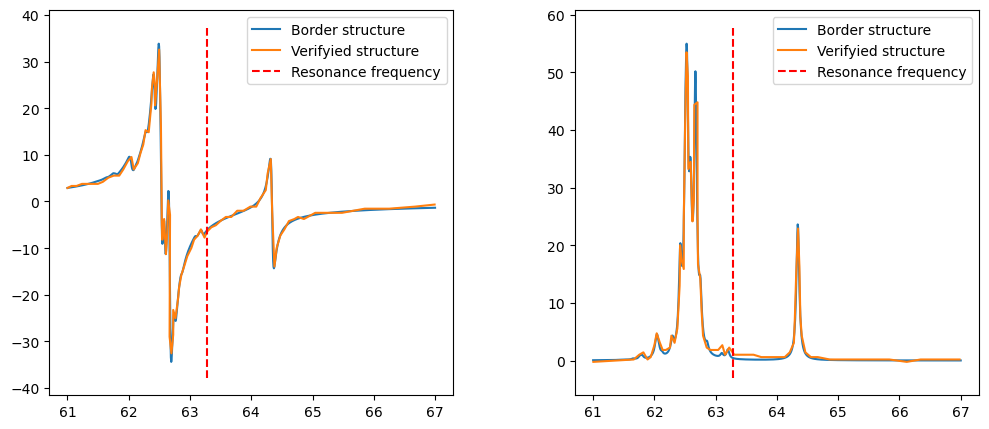

93 93 Flat


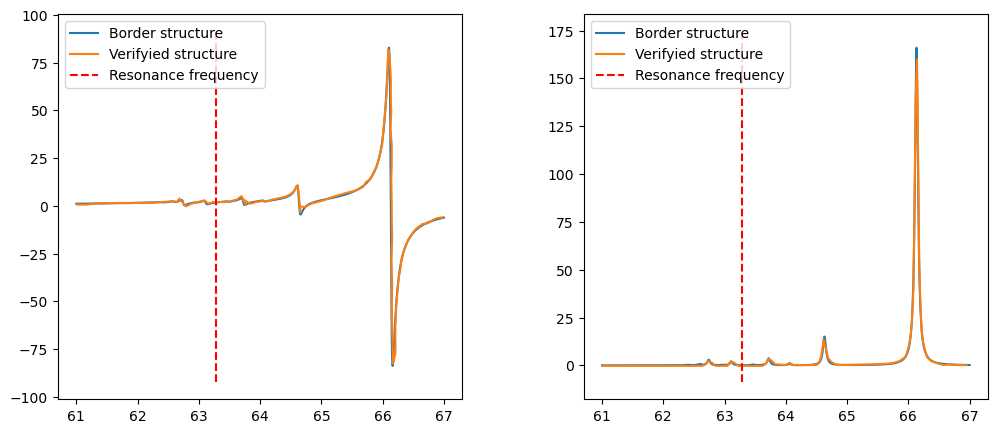

85 85 Cube


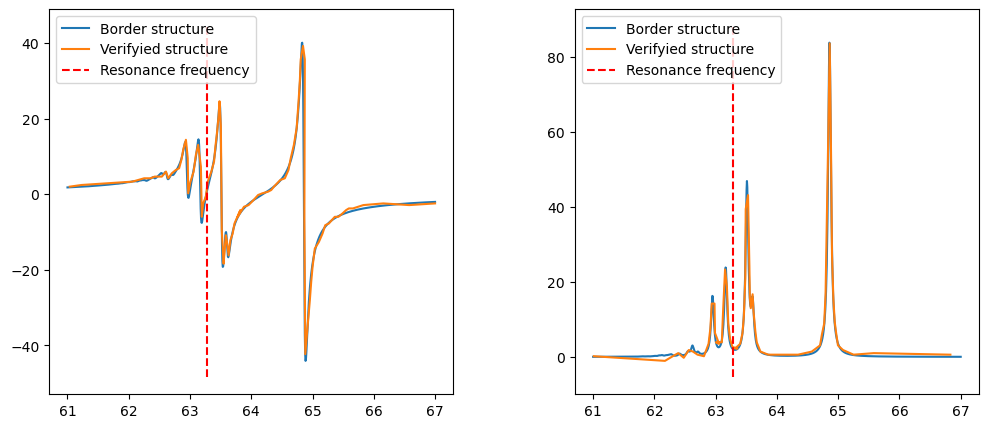

In [11]:
# Getting data from origin plots
import numpy as np
import json

Michle_RealOmega = {}
Michle_RealPolarisation = {}
Michle_ImagOmega = {}
Michle_ImagPolarisation = {}

Michle_RealOmega['Flat'] = [61.01481481481481, 61.096296296296295, 61.17777777777778, 61.266666666666666, 61.67407407407407, 62.2, 62.58518518518518, 62.644444444444446, 62.681481481481484, 62.74074074074074, 62.79259259259259, 62.87407407407407, 63.08888888888889, 63.15555555555556, 63.22962962962963, 63.318518518518516, 63.42962962962963, 63.51851851851852, 63.62222222222222, 63.696296296296296, 63.762962962962966, 63.72592592592593, 63.837037037037035, 63.93333333333333, 64.01481481481481, 64.1037037037037, 64.2074074074074, 64.34074074074074, 64.43703703703704, 64.5111111111111, 64.56296296296296, 64.61481481481482, 64.65925925925926, 64.64444444444445, 64.72592592592592, 64.82962962962964, 64.93333333333334, 65.03703703703704, 65.14074074074074, 65.27407407407408, 65.41481481481482, 65.53333333333333, 65.60740740740741, 65.68148148148148, 65.73333333333333, 65.8, 65.85185185185185, 65.8962962962963, 65.94074074074074, 65.99259259259259, 66.00740740740741, 66.02962962962962, 66.04444444444445, 66.05925925925926, 66.06666666666666, 66.08148148148148, 66.08148148148148, 66.0962962962963, 66.11111111111111, 66.12592592592593, 66.13333333333334, 66.13333333333334, 66.13333333333334, 66.14074074074074, 66.12592592592593, 66.14814814814815, 66.14814814814815, 66.14074074074074, 66.14814814814815, 66.14814814814815, 66.15555555555555, 66.14074074074074, 66.15555555555555, 66.14814814814815, 66.15555555555555, 66.17037037037036, 66.2074074074074, 66.2074074074074, 66.22222222222223, 66.24444444444444, 66.25925925925927, 66.28888888888889, 66.3037037037037, 66.33333333333333, 66.37037037037037, 66.42222222222222, 66.5037037037037, 66.57037037037037, 66.65185185185186, 66.74074074074073, 66.82222222222222, 66.88888888888889, 66.98518518518519]
Michle_RealPolarisation['Flat'] = [0.6648199445983352, 0.6648199445983352, 0.6648199445983352, 1.10803324099723, 1.5512465373961248, 1.5512465373961248, 2.4376731301939145, 1.9944598337950197, 3.767313019390585, 1.5512465373961248, -0.22160664819944031, 1.10803324099723, 2.880886426592795, 1.10803324099723, 1.9944598337950197, 1.9944598337950197, 1.9944598337950197, 2.4376731301939145, 3.32409972299169, 5.096952908587255, 0.6648199445983352, 3.32409972299169, 1.10803324099723, 1.9944598337950197, 2.4376731301939145, 2.4376731301939145, 3.32409972299169, 4.21052631578948, 5.096952908587255, 6.42659279778394, 8.199445983379505, 10.85872576177286, -3.32409972299169, -0.22160664819944031, -0.6648199445983352, 1.10803324099723, 1.9944598337950197, 2.880886426592795, 4.21052631578948, 5.54016620498615, 6.8698060941828345, 7.75623268698061, 8.6426592797784, 9.97229916897507, 12.631578947368425, 13.961218836565095, 17.506925207756233, 20.166204986149587, 25.041551246537395, 32.13296398891967, 37.89473684210527, 45.87257617728532, 51.634349030470915, 56.95290858725762, 62.714681440443215, 69.80609418282549, 75.12465373961219, 81.77285318559557, 77.34072022160665, 71.57894736842105, 65.81717451523545, 60.94182825484765, 55.62326869806094, 48.97506925207756, 40.554016620498615, 32.13296398891967, 21.939058171745152, 13.5180055401662, 0.22160664819945453, -7.313019390581715, -17.063711911357345, -29.473684210526315, -40.11080332409972, -52.07756232686981, -64.93074792243766, -82.65927977839334, -77.34072022160663, -63.15789473684211, -52.07756232686981, -43.65650969529085, -38.337950138504155, -33.019390581717445, -28.587257617728525, -24.5983379501385, -21.49584487534625, -17.506925207756225, -13.5180055401662, -11.30193905817174, -9.529085872576175, -9.08587257617728, -7.313019390581715, -6.4265927977839254, -5.983379501385045]

Michle_RealOmega['Cube'] = [61.03703703703704, 61.22962962962963, 62.05925925925926, 62.25185185185185, 62.355555555555554, 62.422222222222224, 62.54074074074074, 62.60740740740741, 62.644444444444446, 62.7037037037037, 62.77037037037037, 62.82222222222222, 62.85925925925926, 62.888888888888886, 62.93333333333333, 62.96296296296296, 62.97037037037037, 63.007407407407406, 63.05925925925926, 63.096296296296295, 63.13333333333333, 63.17777777777778, 63.19259259259259, 63.214814814814815, 63.25925925925926, 63.28888888888889, 63.34814814814815, 63.39259259259259, 63.41481481481482, 63.43703703703704, 63.46666666666667, 63.48148148148148, 63.50370370370371, 63.51851851851852, 63.54814814814815, 63.56296296296296, 63.58518518518518, 63.60740740740741, 63.62962962962963, 63.65925925925926, 63.696296296296296, 63.72592592592593, 63.82222222222222, 63.77777777777778, 63.88148148148148, 63.955555555555556, 64.03703703703704, 64.11111111111111, 64.17777777777778, 64.27407407407408, 64.32592592592593, 64.37037037037037, 64.42222222222222, 64.47407407407407, 64.54814814814814, 64.60740740740741, 64.64444444444445, 64.6962962962963, 64.74074074074075, 64.77037037037037, 64.7925925925926, 64.80740740740741, 64.84444444444445, 64.87407407407407, 64.86666666666666, 64.88148148148149, 64.91851851851852, 64.95555555555555, 64.97777777777777, 65, 65.03703703703704, 65.1037037037037, 65.16296296296296, 65.2074074074074, 65.26666666666667, 65.36296296296297, 65.42222222222222, 65.4888888888889, 65.54814814814814, 65.5925925925926, 65.65925925925926, 65.82962962962964, 66.15555555555555, 66.57777777777778, 67]
Michle_RealPolarisation['Cube'] = [1.9944598337950197, 2.4376731301939145, 3.32409972299169, 4.21052631578948, 4.21052631578948, 4.6537396121883745, 4.6537396121883745, 5.983379501385045, 4.21052631578948, 5.54016620498615, 6.42659279778394, 6.8698060941828345, 9.08587257617728, 11.745152354570635, 14.40443213296399, 9.529085872576175, 0.22160664819945453, 3.32409972299169, 5.983379501385045, 10.415512465373965, 13.07479224376732, 7.313019390581715, -5.983379501385045, -2.4376731301939003, -0.6648199445983352, 3.32409972299169, 5.983379501385045, 8.6426592797784, 12.631578947368425, 15.73407202216066, 20.609418282548475, 24.598337950138507, 17.950138504155127, -9.529085872576175, -18.393351800554015, -15.290858725761765, -10.858725761772845, -13.074792243767305, -16.177285318559555, -12.18836565096953, -10.415512465373965, -7.75623268698061, -4.2105263157894655, -5.983379501385045, -3.32409972299169, -2.880886426592795, -1.5512465373961248, -0.22160664819944031, 0.22160664819945453, 0.6648199445983352, 1.10803324099723, 1.9944598337950197, 2.880886426592795, 3.767313019390585, 4.21052631578948, 6.42659279778394, 9.529085872576175, 13.07479224376732, 17.506925207756233, 24.155124653739612, 29.91689750692521, 35.67867036011081, 39.22437673130194, 35.67867036011081, -6.4265927977839254, -42.32686980609418, -35.235457063711905, -28.14404432132963, -23.26869806094183, -19.27977839335179, -14.40443213296399, -12.631578947368425, -10.415512465373965, -8.199445983379505, -7.75623268698061, -5.983379501385045, -5.983379501385045, -5.096952908587255, -4.2105263157894655, -3.767313019390585, -3.767313019390585, -2.880886426592795, -2.4376731301939003, -2.880886426592795, -2.4376731301939003]

Michle_RealOmega['Stick'] = [61, 61.06666666666667, 61.148148148148145, 61.237037037037034, 61.32592592592593, 61.407407407407405, 61.49629629629629, 61.577777777777776, 61.666666666666664, 61.75555555555555, 61.84444444444444, 61.91111111111111, 61.98518518518519, 62.044444444444444, 62.08148148148148, 62.148148148148145, 62.19259259259259, 62.237037037037034, 62.27407407407407, 62.32592592592593, 62.34814814814815, 62.370370370370374, 62.37777777777778, 62.407407407407405, 62.42962962962963, 62.42962962962963, 62.45925925925926, 62.49629629629629, 62.525925925925925, 62.54074074074074, 62.54814814814815, 62.577777777777776, 62.592592592592595, 62.60740740740741, 62.629629629629626, 62.644444444444446, 62.67407407407407, 62.666666666666664, 62.696296296296296, 62.72592592592593, 62.72592592592593, 62.762962962962966, 62.80740740740741, 62.82222222222222, 62.85925925925926, 62.903703703703705, 62.955555555555556, 63.022222222222226, 63.06666666666667, 63.12592592592593, 63.17777777777778, 63.237037037037034, 63.28148148148148, 63.34814814814815, 63.34814814814815, 63.422222222222224, 63.49629629629629, 63.58518518518518, 63.67407407407407, 63.77037037037037, 63.87407407407407, 63.98518518518519, 64.08148148148148, 64.14814814814815, 64.23703703703704, 64.26666666666667, 64.31851851851852, 64.34074074074074, 64.37777777777778, 64.41481481481482, 64.47407407407407, 64.54074074074074, 64.61481481481482, 64.70370370370371, 64.76296296296296, 64.85925925925926, 65.04444444444445, 65.48148148148148, 65.85185185185185, 66.25185185185185, 66.67407407407407, 66.67407407407407, 66.99259259259259]
Michle_RealPolarisation['Stick'] = [2.880886426592795, 3.32409972299169, 3.32409972299169, 3.767313019390585, 3.767313019390585, 3.767313019390585, 3.767313019390585, 4.21052631578948, 5.096952908587255, 5.54016620498615, 5.54016620498615, 6.8698060941828345, 8.6426592797784, 9.529085872576175, 6.8698060941828345, 8.199445983379505, 10.415512465373965, 12.18836565096953, 15.29085872576178, 14.847645429362885, 17.950138504155127, 21.05263157894737, 24.155124653739612, 27.70083102493075, 24.598337950138507, 20.609418282548475, 25.48476454293629, 32.57617728531856, 15.73407202216066, -5.096952908587255, -8.199445983379505, -3.767313019390585, -7.75623268698061, -11.30193905817174, -6.4265927977839254, 0.22160664819945453, -2.880886426592795, -29.03047091412742, -32.57617728531855, -28.587257617728525, -23.26869806094183, -25.041551246537395, -20.609418282548475, -18.393351800554015, -15.73407202216066, -13.961218836565095, -11.745152354570635, -9.97229916897507, -8.199445983379505, -7.313019390581715, -5.983379501385045, -7.75623268698061, -6.4265927977839254, -5.54016620498615, -5.54016620498615, -5.096952908587255, -4.2105263157894655, -3.32409972299169, -3.32409972299169, -1.9944598337950055, -1.9944598337950055, -1.10803324099723, -1.10803324099723, 0.6648199445983352, 2.4376731301939145, 5.983379501385045, 9.08587257617728, -1.9944598337950055, -13.961218836565095, -9.97229916897507, -7.313019390581715, -5.983379501385045, -4.2105263157894655, -3.767313019390585, -3.32409972299169, -3.767313019390585, -2.4376731301939003, -2.4376731301939003, -1.5512465373961248, -1.5512465373961248, -1.10803324099723, -1.10803324099723, -0.6648199445983352]

Michle_ImagOmega['Flat'] = [61.01123595505618, 62.63670411985019, 62.68913857677903, 62.734082397003746, 62.7940074906367, 62.853932584269664, 63.048689138576776, 63.10112359550562, 63.153558052434455, 63.22846441947566, 63.61797752808989, 63.67790262172284, 63.72284644194757, 63.7752808988764, 63.827715355805246, 64.00749063670412, 64.05992509363296, 64.11985018726591, 64.49438202247191, 64.54681647940075, 64.57677902621722, 64.59925093632958, 64.61423220973782, 64.65917602996255, 64.68913857677903, 64.74157303370787, 64.83895131086142, 65.44569288389513, 65.71535580524345, 65.85767790262172, 65.9625468164794, 66.00749063670412, 66.0374531835206, 66.05992509363296, 66.08239700374531, 66.09737827715355, 66.11985018726591, 66.14232209737828, 66.16479400749064, 66.17977528089888, 66.20224719101124, 66.21722846441948, 66.23970037453184, 66.26966292134831, 66.30711610486891, 66.374531835206, 66.47940074906367, 66.57677902621722, 66.67415730337079, 66.77902621722846, 66.86142322097378, 66.95131086142322]
Michle_ImagPolarisation['Flat'] = [-0.2359882005899685, -0.2359882005899685, 0.5899705014749266, 2.2418879056047203, 1.4159292035398217, -0.2359882005899685, -0.2359882005899685, 2.2418879056047203, 1.4159292035398217, -0.2359882005899685, -0.2359882005899685, 1.0029498525073741, 3.4808259587020665, 2.2418879056047203, 0.5899705014749266, 0.17699115044247904, 1.4159292035398217, 0.17699115044247904, 0.17699115044247904, 1.4159292035398217, 4.719764011799411, 9.262536873156343, 13.805309734513274, 8.023598820058996, 3.893805309734514, 1.8289085545722727, 0.17699115044247904, 0.5899705014749266, 1.0029498525073741, 2.2418879056047203, 4.719764011799411, 10.08849557522124, 15.457227138643068, 23.716814159292035, 39.823008849557525, 74.10029498525074, 138.93805309734512, 160, 94.74926253687316, 49.32153392330383, 28.672566371681416, 17.93510324483776, 12.15339233038348, 8.436578171091446, 4.3067846607669615, 2.2418879056047203, 1.0029498525073741, 0.17699115044247904, 0.5899705014749266, 0.17699115044247904, 0.17699115044247904, 0.17699115044247904]

Michle_ImagOmega['Stick'] = [61.00374531835206, 61.662921348314605, 61.752808988764045, 61.82022471910113, 61.8876404494382, 61.940074906367045, 62, 62.0374531835206, 62.08988764044944, 62.13483146067416, 62.187265917603, 62.254681647940075, 62.27715355805243, 62.329588014981276, 62.37453183520599, 62.41198501872659, 62.41947565543071, 62.441947565543074, 62.47940074906367, 62.47940074906367, 62.50187265917603, 62.52434456928839, 62.546816479400746, 62.554307116104866, 62.59176029962547, 62.59925093632959, 62.62172284644195, 62.644194756554306, 62.651685393258425, 62.70411985018727, 62.70411985018727, 62.71161048689139, 62.749063670411985, 62.77153558052434, 62.7940074906367, 62.853932584269664, 62.91385767790262, 62.9812734082397, 63.04119850187266, 63.10861423220974, 63.153558052434455, 63.22097378277154, 63.30337078651685, 63.46067415730337, 63.61797752808989, 63.745318352059925, 63.97003745318352, 64.12734082397003, 64.20973782771536, 64.27715355805243, 64.29213483146067, 64.31460674157303, 64.34456928838951, 64.36704119850187, 64.38202247191012, 64.40449438202248, 64.46441947565543, 64.55430711610487, 64.66666666666667, 64.86142322097378, 65.06367041198502, 65.31086142322097, 65.60299625468164, 65.83520599250936, 66.11985018726591, 66.34456928838951, 66.9812734082397]
Michle_ImagPolarisation['Stick'] = [-0.2359882005899685, 0.17699115044247904, 1.0029498525073741, 1.4159292035398217, 0.17699115044247904, 0.5899705014749266, 2.654867256637168, 4.719764011799411, 3.0678466076696154, 1.8289085545722727, 1.8289085545722727, 2.2418879056047203, 4.3067846607669615, 3.0678466076696154, 5.545722713864308, 12.979351032448378, 20, 17.52212389380531, 15.870206489675518, 24.129793510324482, 41.06194690265487, 53.451327433628315, 49.32153392330383, 33.21533923303835, 34.45427728613569, 31.563421828908552, 24.129793510324482, 27.846607669616517, 44.365781710914455, 44.7787610619469, 25.36873156342183, 16.696165191740413, 14.218289085545724, 8.436578171091446, 4.3067846607669615, 2.2418879056047203, 1.8289085545722727, 1.8289085545722727, 1.8289085545722727, 2.654867256637168, 1.0029498525073741, 2.2418879056047203, 1.0029498525073741, 1.0029498525073741, 1.0029498525073741, 0.5899705014749266, 0.5899705014749266, 0.5899705014749266, 1.4159292035398217, 3.0678466076696154, 7.1976401179941, 15.044247787610619, 22.89085545722714, 16.283185840707965, 7.610619469026549, 4.3067846607669615, 1.4159292035398217, 0.5899705014749266, 0.5899705014749266, 0.17699115044247904, 0.17699115044247904, 0.17699115044247904, 0.17699115044247904, 0.17699115044247904, -0.2359882005899685, 0.17699115044247904, 0.17699115044247904]

Michle_ImagOmega['Cube'] = [61.01123595505618, 62.172284644194754, 62.29962546816479, 62.38951310861423, 62.47940074906367, 62.561797752808985, 62.62921348314607, 62.70411985018727, 62.80898876404494, 62.88389513108614, 62.91385767790262, 62.93632958801498, 62.9812734082397, 62.98876404494382, 63.056179775280896, 63.00374531835206, 63.10112359550562, 63.10861423220974, 63.12359550561798, 63.153558052434455, 63.18352059925093, 63.2059925093633, 63.235955056179776, 63.27340823970037, 63.355805243445694, 63.3183520599251, 63.40074906367041, 63.438202247191015, 63.46067415730337, 63.48314606741573, 63.49063670411985, 63.52808988764045, 63.550561797752806, 63.558052434456926, 63.57303370786517, 63.60299625468165, 63.61797752808989, 63.647940074906366, 63.670411985018724, 63.73033707865169, 63.857677902621724, 64.05243445692884, 64.34456928838951, 64.5692883895131, 64.70411985018727, 64.73408239700375, 64.77153558052434, 64.7940074906367, 64.80898876404494, 64.83895131086142, 64.86142322097378, 64.88389513108615, 64.89887640449439, 64.92134831460675, 64.9438202247191, 64.96629213483146, 64.99625468164794, 65.07865168539325, 65.25093632958801, 65.58052434456928, 66.8314606741573]
Michle_ImagPolarisation['Cube'] = [0.17699115044247904, -1.0619469026548671, 0.17699115044247904, 1.0029498525073741, -0.2359882005899685, 1.8289085545722727, 1.4159292035398217, 0.5899705014749266, 0.17699115044247904, 3.4808259587020665, 7.610619469026549, 14.218289085545724, 14.218289085545724, 6.371681415929205, 3.4808259587020665, 3.893805309734514, 3.893805309734514, 7.1976401179941, 12.979351032448378, 23.303834808259587, 18.761061946902654, 8.849557522123893, 4.719764011799411, 2.654867256637168, 2.2418879056047203, 2.2418879056047203, 3.4808259587020665, 6.371681415929205, 10.914454277286136, 20.825958702064895, 39.41002949852508, 43.126843657817105, 24.129793510324482, 15.870206489675518, 12.979351032448378, 16.696165191740413, 12.15339233038348, 6.784660766961652, 3.893805309734514, 1.4159292035398217, 0.5899705014749266, 0.5899705014749266, 0.5899705014749266, 1.4159292035398217, 3.0678466076696154, 5.958702064896755, 8.849557522123893, 16.696165191740413, 31.150442477876105, 60.05899705014749, 83.59882005899705, 53.451327433628315, 27.43362831858407, 15.457227138643068, 9.262536873156343, 6.371681415929205, 3.0678466076696154, 1.8289085545722727, 0.5899705014749266, 1.0029498525073741, 0.5899705014749266]

# Compare different border and open structures

import matplotlib.pyplot as plt

types = ["Stick", "Flat", "Cube"]
mu_0 = 4 * np.pi * 10**-7


for type in types:
    Nz_border, Ny_border, Nx_border = [Shapes_border[type][pos][f'n{pos}']-1 for pos in Shapes_border[type]]

    plt.figure(figsize=(12, 5))
    plt.subplots_adjust(wspace=0.3, hspace=0.3)  

    with open(f"Data/Form_Data/izotropic/{type}/S-Data-zyx-{Nz_border}x{Ny_border}x{Nx_border}", "r") as f:
        Data = json.load(f)
    
    Omega = np.array(Data["Omega"])
    RealPolarisation = np.array(Data["RealZPolarisation"])
    ImagPolarisation = np.array(Data["ImagZPolarisation"])

    plt.subplot(121) 

    plt.plot(Omega/2/np.pi/10**6, RealPolarisation, label = 'Border structure')

    plt.subplot(122)
    plt.plot(Omega/2/np.pi/10**6, ImagPolarisation, label = 'Border structure')

    plt.subplot(121)
    Omega = np.array(Michle_RealOmega[type])
    RealPolarisation = np.array(Michle_RealPolarisation[type])
    print(len(RealPolarisation), len(Omega), type)
    plt.plot(Omega, RealPolarisation, label = 'Verifyied structure')

    plt.subplot(122)
    Omega = np.array(Michle_ImagOmega[type])
    ImagPolarisation = np.array(Michle_ImagPolarisation[type])
    plt.plot(Omega, ImagPolarisation, label = 'Verifyied structure')

    plt.subplot(121)
    ylim = plt.ylim()
    plt.vlines(omega_0/2/np.pi/10**6, ylim[0], ylim[1], color="red", linestyle="--", label='Resonance frequency')
    plt.legend()
    plt.subplot(122)
    ylim = plt.ylim()
    plt.vlines(omega_0/2/np.pi/10**6, ylim[0], ylim[1], color="red", linestyle="--", label='Resonance frequency')
    plt.legend()

    plt.savefig(f'Plots/Report_images/Compare_form_{type}.png')
    plt.show()



23 5 5


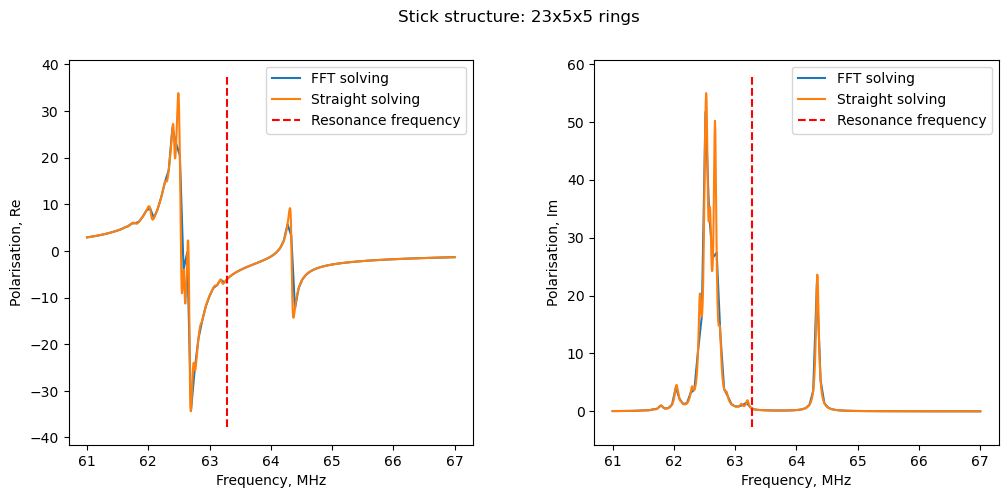

3 15 15


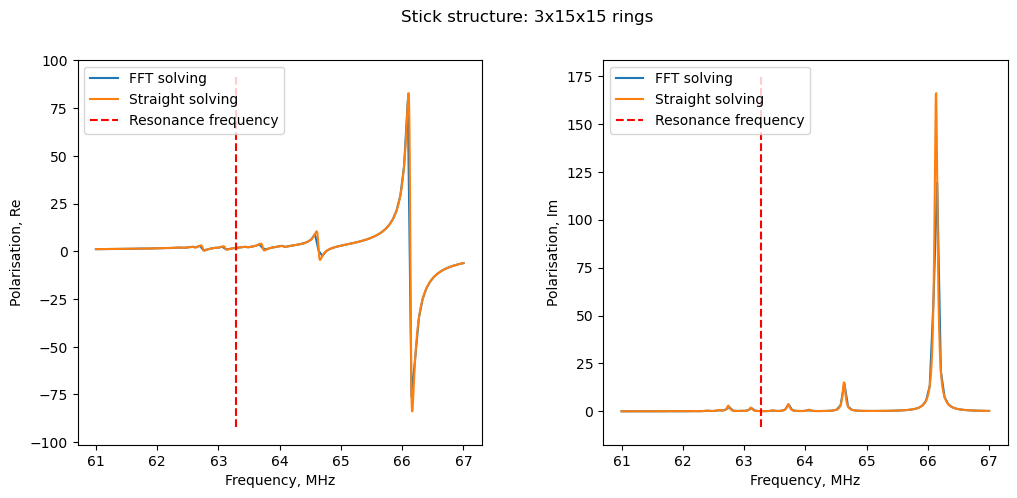

10 10 10


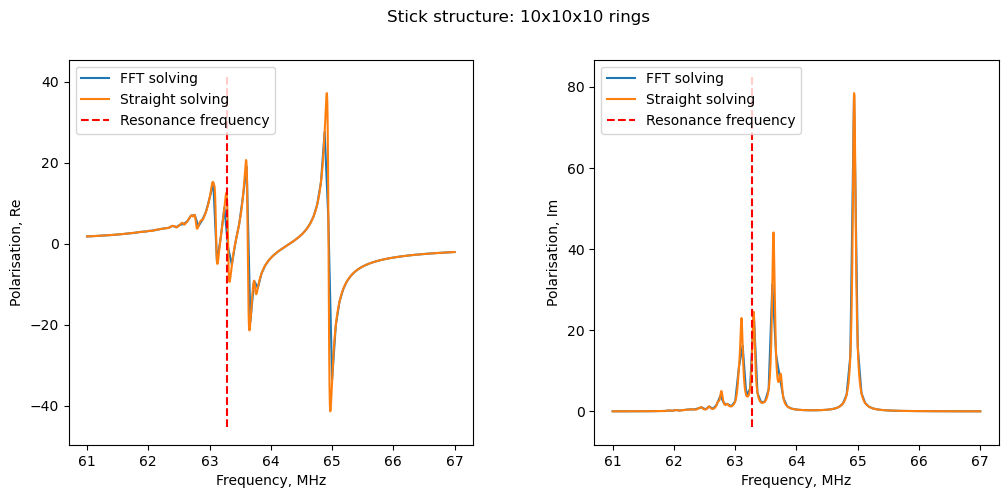

In [5]:
# Compare FFT and straight solving
import matplotlib.pyplot as plt
import numpy as np
import json

from Verifying_MRI.Parameters_MRI import Dz, Dy, Dx, Radius, omega_0, Params
Params['R'] = 0.00465
Params['L'] = 13.459 * 10 ** -9
Params['C'] = 470 * 10 ** -12
import json

Inductance = {}
omega_0 = 1/np.sqrt(Params['L'] * Params['C'])
Omega =  np.linspace(omega_0*0.9, omega_0*1.1, 1000)
H_0z = 1
mu_0 = 4 * np.pi * 1e-7

names = ["Stick", "Flat", "Cube"]
mu_0 = 4 * np.pi * 10**-7

for type, N in zip(types, Shapes_border):
    Nz, Ny, Nx = [Shapes_border[type][pos][f'n{pos}']-1 for pos in Shapes_border[type]]

    print(Nz, Ny, Nx)
    plt.figure(figsize=(12, 5))
    plt.subplots_adjust(wspace=0.3, hspace=0.3)  
    plt.suptitle(f"{name} structure: {Nz}x{Ny}x{Nx} rings")

    with open(f"Data/Form_Data/izotropic/{type}/FFT-Data-zyx-{Nz}x{Ny}x{Nx}", "r") as f:
        Data = json.load(f)
    Omega = np.array(Data["Omega"])
    RealPolarisation = np.array(Data["RealZPolarisation"])
    ImagPolarisation = np.array(Data["ImagZPolarisation"])
    plt.subplot(121)
    

    plt.plot(Omega/2/np.pi/10**6, RealPolarisation, label = 'FFT solving')
    plt.xlabel("Frequency, MHz")
    plt.ylabel("Polarisation, Re")

    plt.subplot(122)
    plt.plot(Omega/2/np.pi/10**6, ImagPolarisation, label = 'FFT solving')
    plt.xlabel("Frequency, MHz")
    plt.ylabel("Polarisation, Im")

    with open(f"Data/Form_Data/izotropic/{type}/S-Data-zyx-{Nz}x{Ny}x{Nx}", "r") as f:
        Data = json.load(f)
    
    Omega = np.array(Data["Omega"])
    RealPolarisation = np.array(Data["RealZPolarisation"])
    ImagPolarisation = np.array(Data["ImagZPolarisation"])

    plt.subplot(121) 
    plt.plot(Omega/2/np.pi/10**6, RealPolarisation, label = 'Straight solving')
    plt.xlabel("Frequency, MHz")
    plt.ylabel("Polarisation, Re")

    plt.subplot(122)
    plt.plot(Omega/2/np.pi/10**6, ImagPolarisation, label = 'Straight solving')
    plt.xlabel("Frequency, MHz")
    plt.ylabel("Polarisation, Im")

    plt.subplot(121)
    ylim = plt.ylim()
    plt.vlines(omega_0/2/np.pi/10**6, ylim[0], ylim[1], color="red", linestyle="--", label='Resonance frequency')
    plt.legend()
    plt.subplot(122)
    ylim = plt.ylim()
    plt.vlines(omega_0/2/np.pi/10**6, ylim[0], ylim[1], color="red", linestyle="--", label='Resonance frequency')
    plt.legend()

    plt.savefig(f'Plots/Report_images/Verify_{name}_{Nz}x{Ny}x{Nx}.png')
    plt.show()



## Anizotropic calculation

In [ ]:
# Calculating currents in each ring on fft way for anizotropic structure
import numpy as np
from Fast_Method import solvesystem
from Geometry import Rectangle_packing
from Impedance_matrix import M_0
from Verifying_MRI.Parameters_MRI import Dz, Dy, Dx, Radius, omega_0, Params
Params['R'] = 0.00465
Params['L'] = 13.459 * 10 ** -9
Params['C'] = 470 * 10 ** -12
omega_0 = 1/np.sqrt(Params['L'] * Params['C'])
import json

Inductance = {}
Omega =  np.linspace(61, 67, 100) * 2 * np.pi * 1e6
omega_0 = 1/np.sqrt(Params['L'] * Params['C'])
H_0z = 1
mu_0 = 4 * np.pi * 1e-7
# Calculate polarisation for different structures

Dz, Dy, Dx = Params['Dz'], Params['Dy'], Params['Dx']
# Initial position of the first ring for each orientation
R0 = {
    'z': {'nz': 0, 'ny': Dy/2, 'nx': Dx/2},
}
compessions = [1, 3, 10]
for compession in compessions:
    for name in Shapes_anizotropic:
        break
        Params['N'] = Shapes_anizotropic[name]
        Params['Dz'] = Dz / compession
        # make 3d structure
        print(f'\n Make rings: {name}, {Params["N"]}, compression: {compession}')
        Rings_4d ={}
        for pos in Params['N']:
            Rings_4d[pos] = Rectangle_packing(Params, r0 = R0[pos], orientation=pos).reshape(
                                                         Params['N'][pos]['nz'],
                                                         Params['N'][pos]['ny'],
                                                         Params['N'][pos]['nx'])
        Params['Number'] = np.sum([Rings_4d[pos].size for pos in Params['N']])

        Currents = solvesystem(Rings_4d, M_0(Params), Omega, phi_0z=H_0z * mu_0*np.pi * Radius ** 2, Inductance = Inductance, tol = 1e-5)

        Nz, Ny, Nx = Params['N']['z'].values()
        Volume =  Nx * Ny * Nz * Dz * Dy * Dx
        P_0z = np.pi * Radius ** 2 /Volume/H_0z
        Currents['Shape'] = Shapes_anizotropic
        Currents['RealPolarisation'] = [P_0z * sum(i) for i in Currents['RealCurrents']]
        Currents['ImagPolarisation'] = [P_0z * sum(i) for i in Currents['ImagCurrents']]
        dims = ''.join([pos for pos in Params['N']])
        with open(f"Data/Form_Data/anizotropic/{name}/{compession}Currents-{dims}-{Nz}x{Ny}x{Nx}", "w") as f:
            json.dump(Currents, f)

        exclude = ['RealCurrents', 'ImagCurrents']
        data = {key: value for key, value in Currents.items() if key not in exclude}
        with open(f"Data/Form_Data/anizotropic/{name}/{compession}Data-{dims}-{Nz}x{Ny}x{Nx}", "w") as f:
            json.dump(data, f)

skin depth 0.9870370562481906 mkm
Inductivity, nGn 3.3641344835696056
Resistance, Ohm 0.01150766539776481


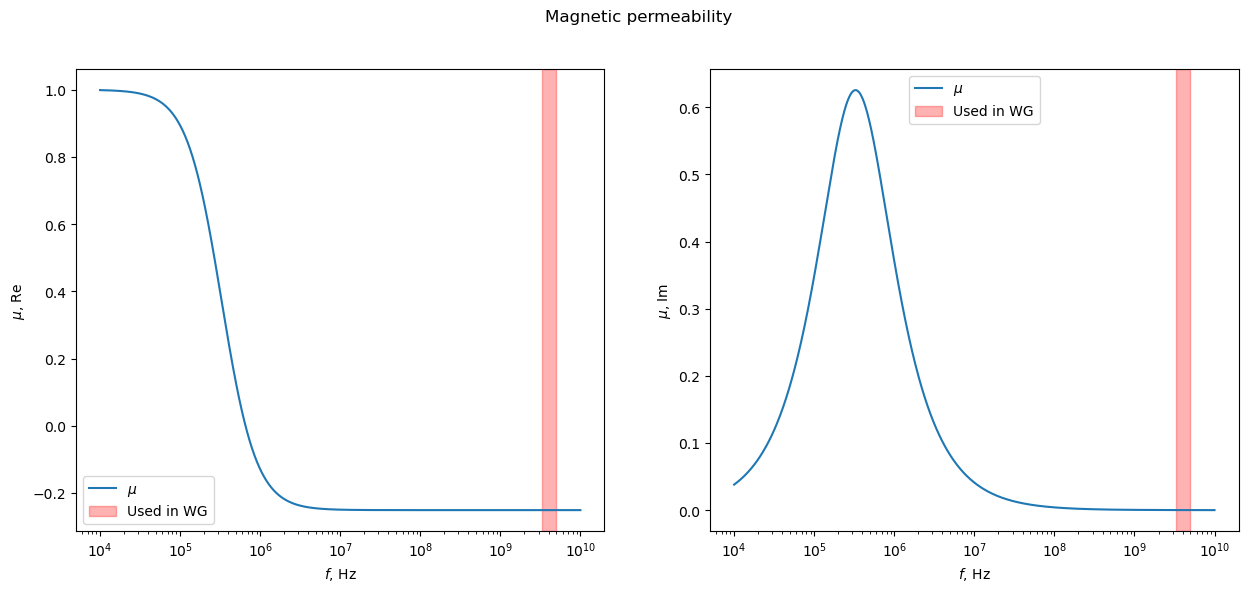

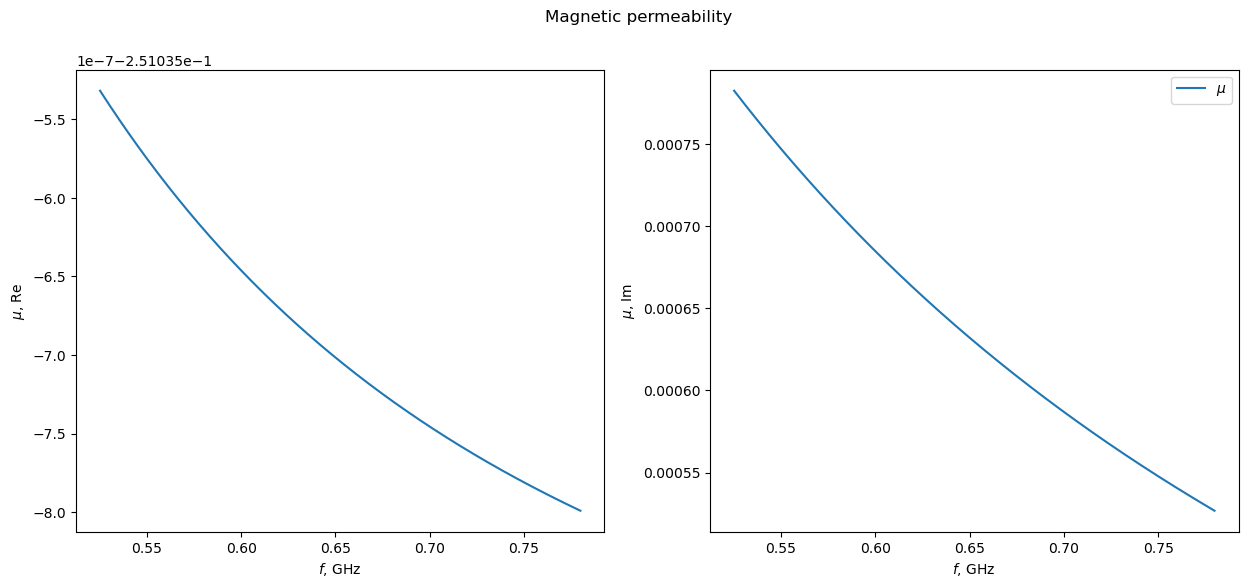

In [ ]:
# Calculating magnetic permeability for experimental structures
from Straight_Method import effective_mu
from Parameters_anisotropic import Params
import numpy as np
import matplotlib.pyplot as plt

mu_0 = 4 * np.pi * 10**-7
e_0 = 8.85 * 10**-12
sigma = 0.65e8              # conductivity for copper S/m


delta = np.sqrt(2/(2*np.pi*4e9*mu_0*sigma)) # skin depth
print('skin depth', delta*1e6, 'mkm')

L = mu_0 * Params['Radius'] * (np.log(8*Params['Radius']/Params['W'])-7/4)
R = 1/(sigma*Params['d']*Params['W']/Params['Radius']/np.pi)

print('Inductivity, nGn', L*1e9)
print('Resistance, Ohm', R)

Params['L'] = L
Params['R'] = R

mu = effective_mu(Params)

# Used frequencies in GHz
Start_omega = 3.3 * 1e9 
End_omega = 4.9 * 1e9 

Omega = np.logspace(4, 10, 1000)*2*np.pi
plt.figure(figsize=(15, 6))
plt.suptitle('Magnetic permeability')
plt.subplot(121)
plt.xlabel(r'$f$, Hz')
plt.ylabel(r'$\mu$, Re')
plt.plot(Omega/2/np.pi, np.real(mu(Omega)), label = r'$\mu$')
plt.axvspan(Start_omega, End_omega, color = 'red', alpha = 0.3, label = 'Used in WG')
plt.legend()
plt.xscale('log')
#plt.yscale('log')
plt.subplot(122)
plt.xlabel(r'$f$, Hz')
plt.ylabel(r'$\mu$, Im')
plt.xscale('log')
#plt.yscale('log')
plt.plot(Omega/2/np.pi, np.imag(mu(Omega)), label = r'$\mu$')
plt.axvspan(Start_omega, End_omega, color = 'red', alpha = 0.3, label = 'Used in WG')
plt.legend()
plt.show()

Omega = np.linspace(Start_omega, End_omega, 1000)

# Plotting result
plt.figure(figsize=(15, 6))
plt.suptitle('Magnetic permeability')
plt.subplot(121)
plt.xlabel(r'$f$, GHz')
plt.ylabel(r'$\mu$, Re')
plt.plot(Omega/2/np.pi/1e9, np.real(mu(Omega)), label = r'$\mu$')
plt.subplot(122)
plt.xlabel(r'$f$, GHz')
plt.ylabel(r'$\mu$, Im')
plt.plot(Omega/2/np.pi/1e9, np.imag(mu(Omega)), label = r'$\mu$')
plt.legend()
plt.show()



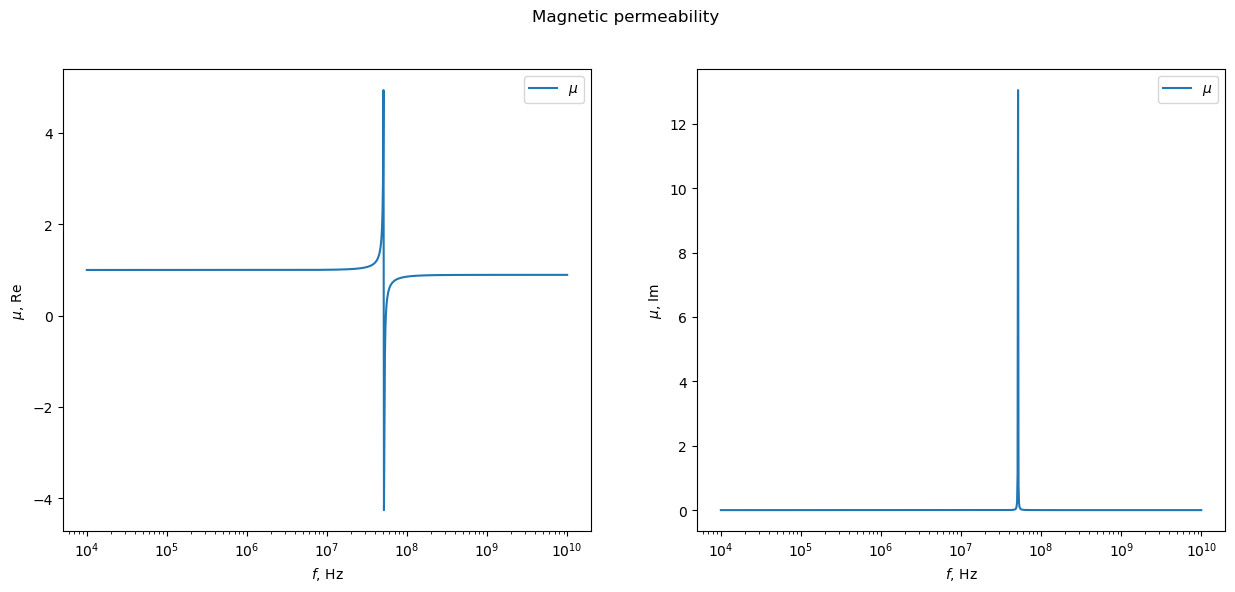

In [2]:
# Calculating magnetic permeability for experimental structures
from Straight_Method import effective_mu
from Parameters_anisotropic import Params
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.animation as anime


fig, ax = plt.subplots()

Omega = np.logspace(4, 10, 1000)*2*np.pi
Sigma = np.linspace(-1, 1, 100)
def plot_GIF(sigma):
    # Clearing figure and set figsize
    plt.clf()
    fig.set_size_inches(15, 6)


    mu = effective_mu(Params)
    Params['Sigma'] = sigma

    plt.suptitle('Magnetic permeability')
    plt.subplot(121)
    plt.xlabel(r'$f$, Hz')
    plt.ylabel(r'$\mu$, Re')
    plt.plot(Omega/2/np.pi, np.real(mu(Omega)), label = r'$\mu$')
    plt.legend()
    plt.xscale('log')
    plt.subplot(122)
    plt.xlabel(r'$f$, Hz')
    plt.ylabel(r'$\mu$, Im')
    plt.xscale('log')
    plt.plot(Omega/2/np.pi, np.imag(mu(Omega)), label = r'$\mu$')
    plt.legend()


        
# Make and save animation object
ani = anime.FuncAnimation(fig, plot_GIF,
                          frames = Sigma,
                          interval = 50
                          )

ani.save(f'Plots/Permeability/TheoryNoResonance.gif', writer='pillow', fps=5, dpi=100)

from Verifying_MRI.Parameters_MRI import Params

def plot_GIF(sigma):
    # Clearing figure and set figsize
    plt.clf()
    fig.set_size_inches(15, 6)


    mu = effective_mu(Params)
    Params['Sigma'] = sigma

    plt.suptitle('Magnetic permeability')
    plt.subplot(121)
    plt.xlabel(r'$f$, Hz')
    plt.ylabel(r'$\mu$, Re')
    plt.plot(Omega/2/np.pi, np.real(mu(Omega)), label = r'$\mu$')
    plt.legend()
    plt.xscale('log')
    plt.subplot(122)
    plt.xlabel(r'$f$, Hz')
    plt.ylabel(r'$\mu$, Im')
    plt.xscale('log')
    plt.plot(Omega/2/np.pi, np.imag(mu(Omega)), label = r'$\mu$')
    plt.legend()


        
# Make and save animation object
ani = anime.FuncAnimation(fig, plot_GIF,
                          frames = Sigma,
                          interval = 50
                          )

ani.save(f'Plots/Permeability/TheoryResonance.gif', writer='pillow', fps=24, dpi=100)